In [1]:
import numpy as np
import cv2
import pandas as pd

from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
# load the y_train and y_test to use in the program
y_train = np.load('orientations_train.npy')
y_test = np.load('orientations_test.npy')

# create a matrix to store the training image data, a row for every data sample
train_matrix=np.empty((10000,4096))
main_path='3dshapes_train/'
jpg='.jpg'
for i in range(10000):
    conv = str(i)
    path = main_path+conv+jpg
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.flatten()
    train_matrix[i]=img
    
# test data is load like the training data
test_matrix=np.zeros((1000,4096))
main_path2='3dshapes_test/'
for i in range(1000):
    conv = str(i)
    path = main_path2+conv+jpg
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.flatten()
    test_matrix[i]=img

## Question 1.a

In [3]:
#In the phase 1 PLS is used for dimensionality reduction. So use again PLS for dimensionality reduction. Extract 100 features
#In the phase 1, image files has been read in wrong order, so the MSE was approximately 500. So the number of extracted features
#was not chosen according to the mse result with dimensionality reduction.
#therefore before starting phase 2, phase1 code is updated and according to the mse results with different number of extracted
#features, number of extracted feature is chosen as 100

from sklearn.cross_decomposition import PLSRegression
model = PLSRegression(n_components=100)
model.fit(train_matrix, y_train)

train_matrix=model.transform(train_matrix)
test_matrix=model.transform(test_matrix)

Text(0.5, 1.0, 'Figure 1. Dimensionality Reduction')

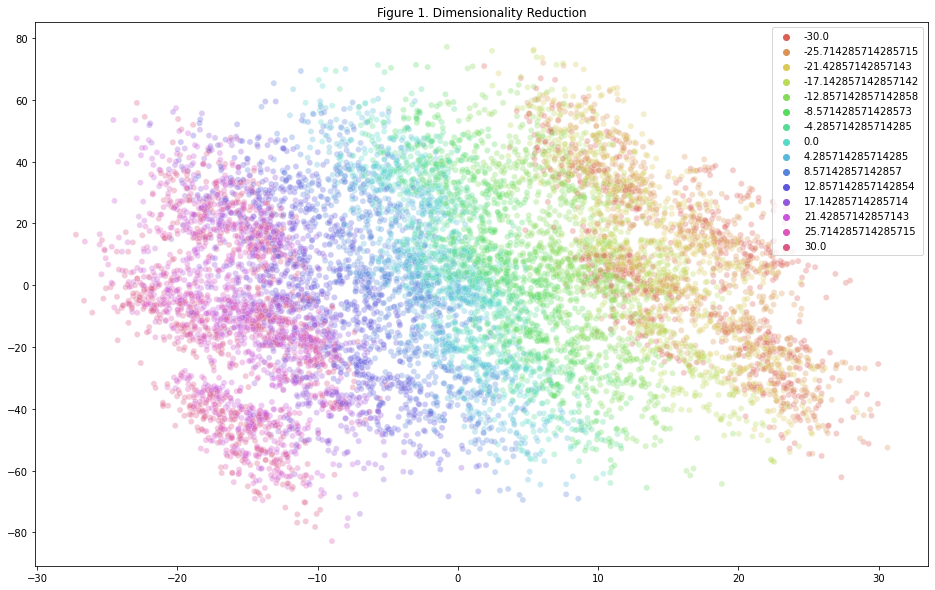

In [4]:
# Plot data when only dimensionality reduction technique (PLS) is applied.
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=train_matrix[:,0], y=train_matrix[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 15),
    data=train_matrix,
    legend="full",
    alpha=0.3
)
plt.title('Figure 1. Dimensionality Reduction')

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Figure 2. TSNE')

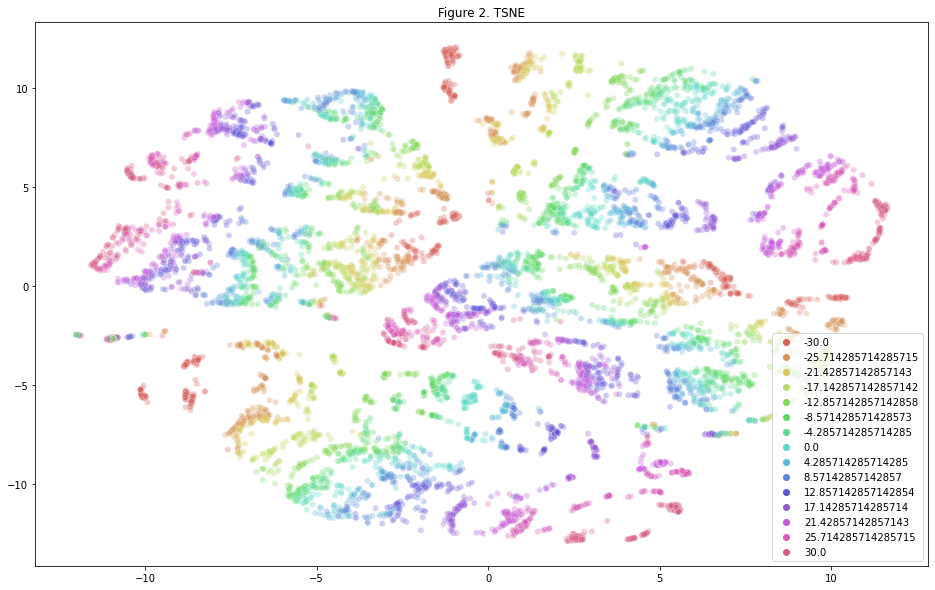

In [5]:
#using t-SNE with the extracted features with PLS
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pls_results = tsne.fit_transform(train_matrix)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_pls_results[:,0], y=tsne_pls_results[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 15),
    data=train_matrix,
    legend="full",
    alpha=0.3
)
plt.title('Figure 2. TSNE')

##### Comment on the discriminability of your features.
When dimensionality reduction PLS is applied features decreased from 4096 to 100, it can clearly seen from Figure 1 that there is seperate decision boundaries between features. However, in the Figure 2, it is seen that features are still seperable but it is less clear compared to Figure 1. There is more partially seperable features for the TSNE case. However, we still think TSNE figure gives us the conlusion our features are seperable. The reason behind less obvious seperabilty may caused of decreasing dimensionality from 100 features to 2 features.

## Question 1.b 

Since this classification problem is a multi class classification, we use the cross entropy loss function with softmax function as hypothesis function. The softmax function is: $$y_i = \frac{e^{z_i}}{\sum_j^C e^{z_j}} $$ the derivative of if respect to $z_i$ is
$$\frac{\partial y_i}{\partial z_i} = \frac{e^{z_i}\sum_j^C e^{z_j} - ({e^{z_i}})^2}{({\sum_j^C e^{z_j}})^2} = \frac{e^{z_i}}{\sum_j^C e^{z_j}} - \frac{({e^{z_i}})^2}{({\sum_j^C e^{z_j}})^2} $$
$$\frac{\partial y_i}{\partial z_i} = y_i(1-y_i) $$ 
The cross entropy loss function is $$CE = -\sum_i^C t_i log(y_i) $$ where $C$ is the number of labels. The derivative of the cross entropy loss respect to $z_i$ $$\frac{\partial CE}{\partial z_i} = \sum_j \frac{\partial CE}{\partial y_j} \frac{\partial y_j}{\partial z_i} = y_i - t_i$$
Since $z_i = wx_i$ for our logistic regression problem, the derivative of the input of softmax function, $z_i$, respect to w: $$\frac{\partial z_i}{\partial w} = x^T $$

The derivative of the cross entropy loss function respect to $w$ (the wanted derivative in the question) $$ {\frac{\partial CE}{\partial w}} = \frac{\partial CE}{\partial z_i} \frac{\partial z_i}{\partial w} =(y_i - t_i) x^T $$
Note that since we want to obtain the probability values for each label of every samples, we transformed the target vector to one hot encoded. Thus, for a data sample $i$, $t_i$ becomes a $15x1$ vector. The extracted data with 1 for bias value makes an input sample $x$ in the form of $121x1$, and for these dimensions $w$ is a $15x121$ matrix

In [6]:
#create functions for step of the logistic regression, gradient descent and accuracy calculation after obtaining "w"
#softmax is the hypothesis function. it takes Wx where W is the model weights and x is "an input sample"
#it calculates probability values for each label for the given input x in Wx
def softmax(logit):
    probability = np.exp(logit - np.max(logit))/np.sum(np.exp(logit - np.max(logit)))#subtract max of logit vector to prevent overflowing error
    return probability
#cross entropy loss calculates loss for an input sample  
def CrossEntropy(target, probability):
    loss = -np.sum(target * np.log(probability + 1e-10 ))#1e-10 is added to prevent divide by zero error. By using the output of the softmax, cross entropy loss is calculated
    return loss
#calculate derivative of loss respect to w    
def grad_w(x, probability, target):
    grad_logits = probability - target
    grad_logits = grad_logits.reshape(-1,1)
    x = x.reshape(1,-1)
    return np.dot(grad_logits,x)
#find the accuracy of the sample
def accuracy(probability, target):
    if (np.argmax(probability)==np.argmax(target)):
        acc = 1
        return acc
    else:
        acc =0
        return acc
#full batch gradient descent function
#by using the function defined above it finds grad_w for every sample, accumulates them and at the end of each iteration updates the grad_w
#it also calculates accuracy and loss values for every iteration
def full_grad_desc(w, x_train, y_train, step_size, iteration_num):
    for i in range(iteration_num):
        sum_loss = sum_acc = sum_grad = 0
        for j in range(x_train.shape[0]):
            
            prob = softmax(np.dot(w, x_train[j]))
            loss = CrossEntropy(y_train[j], prob)
            acc = accuracy(prob,y_train[j])

            grad = grad_w(x_train[j], prob, y_train[j])

            sum_loss += loss
            sum_acc += acc
            sum_grad += grad

        sum_loss = sum_loss/x_train.shape[0]
        sum_acc = sum_acc/x_train.shape[0]
        sum_grad = sum_grad/x_train.shape[0]

        w = w - step_size*sum_grad
    return sum_loss, sum_acc, w      
#test function is created to calculate loss and accuracy using weights after training
#it can be used to calculate the loss and accuracy of both training and test data
def test(x, y, w):
    sum_l = sum_a = 0
    for j in range(x.shape[0]):
        prob = softmax(np.dot(w, x[j]))
        loss = CrossEntropy(y[j], prob)
        acc = accuracy(prob,y[j])
        sum_l += loss
        sum_a += acc
    
    sum_l = sum_l/x.shape[0]
    sum_a = sum_a/x.shape[0]
    
    return sum_l, sum_a

In [7]:
#onehot encoder is used to use the target(output) data easily with the cross entropy function defined above.
#in the cross entropy loss function, loss of an input sample is calculated. this is done by the summing multiplications of
#every element of the target vector with log of corresponding element of the output of the softmax which is the probability of
#the corresponding label.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train=ohe.fit_transform(y_train.reshape(-1,1)).toarray()
y_test=ohe.transform(y_test.reshape(-1,1)).toarray()

## Question 1.c 

In [8]:
#add 1s as fisrt coloumn to test and train matrices to add directly bias values by multiplying it with w
X_test = np.hstack((np.ones(1000).reshape(1000,1), test_matrix))
X_train = np.hstack((np.ones(10000).reshape(10000,1), train_matrix))
#initialize w randomly. note that w is in matrix form since the y_train and y_test is transformed to one hot encoded 
w_initial = np.random.randn(y_train.shape[1],X_test.shape[1])

In [9]:
#s-fold cross validation for hyperparameter tuning. the tuned hyperparameter is the step-size
k_folds = 5 
X_folds = np.split(X_train, k_folds)
y_folds = np.split(y_train, k_folds)

iteration_num = 100
step_size =[0.01, 0.05, 0.1, 0.5, 1]
for s in range(len(step_size)):
    folds_loss = np.empty(k_folds)
    folds_acc = np.empty(k_folds)
    for i in range(k_folds):
        X_temp = X_folds.copy()
        y_temp = y_folds.copy()

        X_test_folded = X_temp.pop(i)
        y_test_folded = y_temp.pop(i)

        X_train_folded = np.vstack(X_temp)
        y_train_folded = np.vstack(y_temp)

        _,_,w = full_grad_desc(w_initial, X_train_folded, y_train_folded, step_size[s], iteration_num)
        loss, acc = test(X_test_folded, y_test_folded, w)
        folds_loss[i] = loss
        folds_acc[i] = acc
        print("Step Size:{} Fold:{} Test Loss: {:.3f} Test Accuracy: {:.3f}".format(step_size[s],i+1, loss, acc))

    std_loss = np.std(folds_loss)
    avg_loss = np.mean(folds_loss)
    avg_acc = np.mean(folds_acc)
    print("Step Size:{} Avg Loss of 5-folds: {:.5f} Standard Deviation of Loss Values of 5-folds: {:.5f} Avg Accuracy of 5-folds: {:.5f}".format(step_size[s],avg_loss,std_loss,avg_acc))

   
    

Step Size:0.01 Fold:1 Test Loss: 16.585 Test Accuracy: 0.128
Step Size:0.01 Fold:2 Test Loss: 17.057 Test Accuracy: 0.128
Step Size:0.01 Fold:3 Test Loss: 16.542 Test Accuracy: 0.135
Step Size:0.01 Fold:4 Test Loss: 16.487 Test Accuracy: 0.128
Step Size:0.01 Fold:5 Test Loss: 15.873 Test Accuracy: 0.151
Step Size:0.01 Avg Loss of 5-folds: 16.50871 Standard Deviation of Loss Values of 5-folds: 0.37757 Avg Accuracy of 5-folds: 0.13390
Step Size:0.05 Fold:1 Test Loss: 5.477 Test Accuracy: 0.509
Step Size:0.05 Fold:2 Test Loss: 6.348 Test Accuracy: 0.490
Step Size:0.05 Fold:3 Test Loss: 5.788 Test Accuracy: 0.511
Step Size:0.05 Fold:4 Test Loss: 5.774 Test Accuracy: 0.523
Step Size:0.05 Fold:5 Test Loss: 5.133 Test Accuracy: 0.553
Step Size:0.05 Avg Loss of 5-folds: 5.70420 Standard Deviation of Loss Values of 5-folds: 0.40095 Avg Accuracy of 5-folds: 0.51760
Step Size:0.1 Fold:1 Test Loss: 2.705 Test Accuracy: 0.725
Step Size:0.1 Fold:2 Test Loss: 3.183 Test Accuracy: 0.679
Step Size:0.1 

## Question 1.d 

In [10]:
# optimize the model for the same initial w, step_size =0.5 and for the same iteration number above.
# step_size is chosen by looking 3 results above which are mean loss of folds, mean accuracy of folds and standard derivation of
# fold losses.
# as seen above, avg. loss values for the first 3 step-size are so high and also their avg. accuracy values are low.
# In the last 2 step size accuracy values are better than the other ones'. But since both the accuracy and loss values of the 5th are better
# than the 4th and also, its standard dev. is lower than 4th one's std. dev, as step size 5th is chosen.

#According to the chosen step size and the other determined parameters train the model.
#update the w and after the training, use the updated w to measure both training and testing accuracy.
step_size = 1
iteration_num = 100
_,_,w = full_grad_desc(w_initial,X_train,y_train,step_size, iteration_num)

#calculate training accuracy
sum_l, sum_a = test(X_train, y_train, w)
print("Training Loss: {} Training Accuracy: {}".format(sum_l, sum_a))

#calculate testing accuracy
sum_l, sum_a = test(X_test, y_test, w)
print("Test Loss: {} Test Accuracy: {}".format(sum_l, sum_a))

Training Loss: 0.08771808661831809 Training Accuracy: 0.988
Test Loss: 0.14565499133145854 Test Accuracy: 0.98


## Question 1.g

Since we used onehot encoded output, our weight is in a matrix form, not a vector, and it is 15x101, 15 comes from the number of label and 101 is the number of features. Because of that we can't see easily the corresponding features for the #weights. But we can take the average of the w values that correspond to the different labels of the same feature. Thus we can look average effect on different labels of a feature.
Below we sort the indexes of features from the most contributed to the lowest contributed by looking the indexes of the averaged "w" across the labels. The features that contributes negatively in average is not printed since these features affect negatively so they are not important actually. We also printed the w[0] to compare with the w[0] of the loss with L1 norm regularization

In [11]:
avg_w1 = np.mean(w, axis=0)
avg_w1_indexes = list()
for i in range(101):
    index = np.argmax(avg_w1)
    if avg_w1[index] == 0:
        break
    avg_w1_indexes.append(index+1)
    avg_w1[index] = 0
print("The list of input features in the order of maximum to minimum effect on average contribution to every class label: ")
print(avg_w1_indexes)

The list of input features in the order of maximum to minimum effect on average contribution to every class label: 
[38, 6, 90, 53, 97, 44, 86, 89, 26, 46, 28, 94, 85, 92, 81, 23, 30, 98, 64, 43, 27, 72, 29, 73, 59, 96, 37, 100, 16, 5, 76, 9, 14, 70, 11, 71, 99, 34, 63, 40, 101, 21, 67, 52, 79]


In [12]:
print(w[0])

[ 0.91740541  4.15097305  0.39416453 -0.66628425  1.27771298  0.73198931
  0.04779454  4.16059252 -0.92937738  2.15456701 -1.3125317  -1.33104263
 -2.09242819  0.69834352 -1.74227461 -0.67923271 -1.74062673  2.08135768
  0.12045172  2.69954351 -1.02518617  1.8700633  -1.67860397 -0.07420319
 -0.45499247  0.08090149 -0.9263457   0.02469966  0.09314953  0.04173568
  0.96626741  0.9126208   1.02052743 -0.28371248 -0.67482482  1.25406148
  0.07296242 -0.11799135  0.29719177 -0.07507105 -0.3625117  -0.21009912
  0.7192966   1.7078353  -0.09274106 -0.48384899 -0.83668269 -0.43457996
 -1.6744911   0.12099523  0.61325575  0.47999864  0.36705854 -0.04347044
  0.5198914   0.51911132  0.86410069  0.85776547 -0.24589816 -0.35879962
 -0.22160018  1.40713124 -1.4789287  -0.85512656 -2.33466944  0.7377147
 -0.25013623 -0.65430271  1.23637135 -1.19868654 -0.93763848  1.35623705
  0.74584375  1.9442386   0.056776    0.57456412 -0.716742   -0.39625886
 -0.74070721 -0.80282739  0.33133207  1.15595994 -0.

## Question 1.h

In [13]:
def grad_desc_lasso(w, x_train, y_train, step_size, iteration_num, lambd):
    for i in range(iteration_num):
        sum_loss = sum_acc = sum_grad = 0
        for j in range(x_train.shape[0]):
            
            prob = softmax(np.dot(w, x_train[j]))
            loss = CrossEntropy(y_train[j], prob)
            acc = accuracy(prob,y_train[j])

            grad = grad_w(x_train[j], prob, y_train[j])

            sum_loss += loss
            sum_acc += acc
            sum_grad += grad

        sum_loss = sum_loss/x_train.shape[0] + np.sum(np.absolute(w))*lambd/(2*x_train.shape[0])#add the L1 reg term
        sum_acc = sum_acc/x_train.shape[0]
        sum_grad = sum_grad/x_train.shape[0]

        w = w - step_size*sum_grad
        #soft thresholding
        
        w[(w <= lambd*step_size)&(w >= -lambd*step_size)] = 0
        w[w > lambd*step_size] = w[w > lambd*step_size] - lambd*step_size
        w[w < -lambd*step_size] = w[w < -lambd*step_size] + lambd*step_size
        
        
    return sum_loss, sum_acc, w
def test_lasso(x, y, w,lambd):
    sum_l = sum_a = 0
    for j in range(x.shape[0]):
        prob = softmax(np.dot(w, x[j]))
        loss = CrossEntropy(y[j], prob)
        acc = accuracy(prob,y[j])
        sum_l += loss
        sum_a += acc
    
    sum_l = sum_l/x.shape[0] + np.sum(np.absolute(w))*lambd/(2*x.shape[0])
    sum_a = sum_a/x.shape[0]
    
    return sum_l, sum_a

In [14]:
#s-fold cross validation for hyperparameter tuning. the tuned hyperparameter is the lambda
k_folds = 5 
X_folds = np.split(X_train, k_folds)
y_folds = np.split(y_train, k_folds)

iteration_num = 100
step_size =1
lambd =[0.1,0.01,0.001]
for s in range(len(lambd)):
    folds_loss = np.empty(k_folds)
    folds_acc = np.empty(k_folds)
    for i in range(k_folds):
        X_temp = X_folds.copy()
        y_temp = y_folds.copy()

        X_test_folded = X_temp.pop(i)
        y_test_folded = y_temp.pop(i)

        X_train_folded = np.vstack(X_temp)
        y_train_folded = np.vstack(y_temp)

        _,_,w2 = grad_desc_lasso(w_initial, X_train_folded, y_train_folded, step_size, iteration_num,lambd[s])
        loss, acc = test_lasso(X_test_folded, y_test_folded, w2,lambd[s])
        folds_loss[i] = loss
        folds_acc[i] = acc
        print("Lambda:{} Fold:{} Test Loss: {:.3f} Test Accuracy: {:.3f}".format(lambd[s],i+1, loss, acc))

    std_loss = np.std(folds_loss)
    avg_loss = np.mean(folds_loss)
    avg_acc = np.mean(folds_acc)
    print("Lambda:{} Avg Loss of 5-folds: {:.5f} Standard Deviation of Loss Values of 5-folds: {:.5f} Avg Accuracy of 5-folds: {:.5f}".format(lambd[s],avg_loss,std_loss,avg_acc))


Lambda:0.1 Fold:1 Test Loss: 11.867 Test Accuracy: 0.400
Lambda:0.1 Fold:2 Test Loss: 11.865 Test Accuracy: 0.375
Lambda:0.1 Fold:3 Test Loss: 12.502 Test Accuracy: 0.376
Lambda:0.1 Fold:4 Test Loss: 13.703 Test Accuracy: 0.320
Lambda:0.1 Fold:5 Test Loss: 10.067 Test Accuracy: 0.446
Lambda:0.1 Avg Loss of 5-folds: 12.00075 Standard Deviation of Loss Values of 5-folds: 1.17698 Avg Accuracy of 5-folds: 0.38320
Lambda:0.01 Fold:1 Test Loss: 1.630 Test Accuracy: 0.883
Lambda:0.01 Fold:2 Test Loss: 0.266 Test Accuracy: 0.957
Lambda:0.01 Fold:3 Test Loss: 0.847 Test Accuracy: 0.927
Lambda:0.01 Fold:4 Test Loss: 2.465 Test Accuracy: 0.826
Lambda:0.01 Fold:5 Test Loss: 1.288 Test Accuracy: 0.917
Lambda:0.01 Avg Loss of 5-folds: 1.29911 Standard Deviation of Loss Values of 5-folds: 0.74027 Avg Accuracy of 5-folds: 0.90200
Lambda:0.001 Fold:1 Test Loss: 0.259 Test Accuracy: 0.974
Lambda:0.001 Fold:2 Test Loss: 0.374 Test Accuracy: 0.959
Lambda:0.001 Fold:3 Test Loss: 0.153 Test Accuracy: 0.980


In [15]:
#since the highest avg value and the lowest std. deviation comes when lambd = 0.001, lambda is chosen as 0.001
step_size = 1
iteration_num = 100
lambd =0.001
_,_,w2 = grad_desc_lasso(w_initial,X_train,y_train,step_size, iteration_num,lambd)

#calculate training accuracy
sum_l, sum_a = test_lasso(X_train, y_train, w2,lambd)
print("Training Loss: {} Training Accuracy: {}".format(sum_l, sum_a))

#calculate testing accuracy
sum_l, sum_a = test(X_test, y_test, w2)
print("Test Loss: {} Test Accuracy: {}".format(sum_l, sum_a))

Training Loss: 0.07730886810160068 Training Accuracy: 0.9886
Test Loss: 0.12373753216285871 Test Accuracy: 0.982


Because of the same reason in (g), we can't see easily the contribution of every feature. But we do the same process in (g) below to see any difference in average contributions of features. But also manually we examined the w values with and without L1 normalization. With L1 normalization we see 0 values but not so much. We also manually check the w values for different lambda values. We see that when lambda becomes higher, we see more 0 values in "w". Actually it can be guessed, because when we increase the lambda, the effect of the regularization increases.
However as we said above, we cant see the contribution of every feature because of the matrix structure of "w". (if it were a vector we can see and comment easily).
We also print w[0] as an example from "w" to see the 0 values and we can see the difference between this w[0] and the w[0] obtained from loss function without regression. They are not the same and we can see the 0 values in w[0] of lasso regularization.

In [16]:
avg_w2 = np.mean(w2, axis=0)
avg_w2_indexes = list()
for i in range(101):
    index = np.argmax(avg_w2)
    if avg_w2[index] == 0:
        break
    avg_w2_indexes.append(index+1)
    avg_w2[index] = 0
print("The list of input features in the order of maximum to minimum effect on average contribution to every class label: ")
print(avg_w2_indexes)

The list of input features in the order of maximum to minimum effect on average contribution to every class label: 
[38, 6, 90, 86, 53, 97, 44, 26, 89, 46, 94, 85, 28, 92, 23, 81, 30, 98, 64, 27, 72, 43, 73, 59, 16, 100, 29, 37, 96, 5, 9, 76, 14, 11, 71, 34, 99, 40, 70, 63, 21, 95, 101, 67, 52]


In [17]:
print(w2[0])

[ 8.25673205e-01  4.05737249e+00  3.62501612e-01 -5.98703521e-01
  1.17252527e+00  6.55048887e-01  7.15075372e-02  4.05703270e+00
 -8.32419238e-01  2.06609908e+00 -1.22231375e+00 -1.25663509e+00
 -1.97245118e+00  5.79423706e-01 -1.63992659e+00 -6.01991091e-01
 -1.63661432e+00  1.97110392e+00  3.76935306e-02  2.60217894e+00
 -9.27117659e-01  1.78306951e+00 -1.58870254e+00 -2.64790445e-04
 -3.79811608e-01  5.56202692e-03 -8.31297958e-01 -9.89591923e-03
  2.83836540e-02 -1.87974897e-02  8.78381312e-01  8.24912092e-01
  9.49207291e-01 -2.06256987e-01 -5.85479227e-01  1.16394574e+00
  4.56008855e-02 -2.51898783e-02  2.03746011e-01  0.00000000e+00
 -2.74347724e-01 -1.16029213e-01  6.22792155e-01  1.64333048e+00
 -3.01718108e-03 -3.76751170e-01 -7.52376696e-01 -3.40052912e-01
 -1.58973658e+00  7.41451837e-02  5.12903271e-01  3.94661182e-01
  2.55698912e-01  1.18993410e-02  4.20593716e-01  4.24807199e-01
  7.63584347e-01  7.64268389e-01 -1.54650223e-01 -2.60315906e-01
 -1.24767916e-01  1.31407

# Question 2

## Question 2.a 

In [18]:
#to use the naive bayes classifier of scikit-learn, load the label data again and make it encoded with labelencoder
y_train = np.load('orientations_train.npy')
y_test = np.load('orientations_test.npy')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#fit naive bayes classifier
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(train_matrix, y_train)

#calculate train accuracy
y_train_pred = classifier.predict(train_matrix)
acc = 0
for i in range(y_train.shape[0]):
    if y_train[i] == y_train_pred[i]:
        acc += 1
acc = acc/y_train.shape[0]
print("Train Accuracy of Naive Bayes: {}".format(acc))

#calculate test accuracy
y_test_pred = classifier.predict(test_matrix)
acc = 0
for i in range(y_test.shape[0]):
    if y_test[i] == y_test_pred[i]:
        acc += 1
acc = acc/y_test.shape[0]
print("Test Accuracy of Naive Bayes: {}".format(acc))

Train Accuracy of Naive Bayes: 0.9335
Test Accuracy of Naive Bayes: 0.932


As seen above, the training accuracy is 93.35%, and test accuracy is 93.2%. Training and test accuracy values are approximately 5% lower than the training and test accuracy of the logistic regression classifier in the first question as guessed due to the assumption of the conditional probability of the Naive Bayes classifier.

## Question 2.b 

The conditional independence assumption of Naive Bayes classifier hold for the extracted features because the dimensionality reduction extracts features that are linearly independent from each other. Since they are independent from each other without condition, they are also conditionaly independent from each other.

## Question 2.c 

Let $d$ be the number of features in the input data and $k$ be the number of output labels, then the number of parameters with the conditional assumption is $$2d(k-1)$$The number of parameters without the conditional assumption is $$ 2(k^d-1)$$Since $d=100$ and $k=15$ for this dataset and extracted features, the number of parameters with the conditional assumption is $2800$

the number of parameters without the conditional assumption is $2(15^{100}-1) = 8.131x10^{117}$